In [1]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
import pytensor.tensor as pt
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


### Q1: Define
#### 1. Gaussian Processes (GPs) and Stochastic Processes Generally

A **stochastic process** is a collection of random variables indexed by time, space, or some other variable, it is written as:

$
\{X_t\}_{t \in T}
$

- $ T $ is the index set.
- Each $ X_t $ is a random variable.
- Examples include time series data and spatial temperature variations.

A **Gaussian Process (GP)** is a specific type of stochastic process where **any finite collection** of the random variables follows a **multivariate normal distribution**.

A GP is fully defined by a **mean function** and a **covariance (kernel) function**:

$
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$

- $ m(x) = \mathbb{E}[f(x)] $ is the mean function.
- $ k(x, x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))] $ is the covariance function.


#### 2. Variational Inference using the Evidence Lower Bound (ELBO)

**Variational Inference (VI)** is an approximate inference method used when the true posterior distribution $ p(\theta \mid x) $ is intractable.

Instead of computing $ p(\theta \mid x) $ directly, we:
1. Choose a simpler family of distributions $ q(\theta) $.
2. Optimize $ q(\theta) $ o be close to the true posterior.

This leads to maximizing the **Evidence Lower Bound (ELBO)**, which is a lower bound on the log marginal likelihood $ \log p(x) $:

$
\log p(x) \geq \mathbb{E}_{q(\theta)}[\log p(x, \theta)] - \mathbb{E}_{q(\theta)}[\log q(\theta)] = \text{ELBO}
$

- The first term encourages fitting the data well.
- The second term acts as a regularizer, keeping $ q(\theta) $ close to the prior.

Maximize the ELBO to find the best approximate posterior $ q(\theta) $.


Q2.This demonstration shows how to use PyMC's Gaussian Process functionality to model and predict electricity demand patterns,  this focuses on hourly electricity demand with daily cycles.


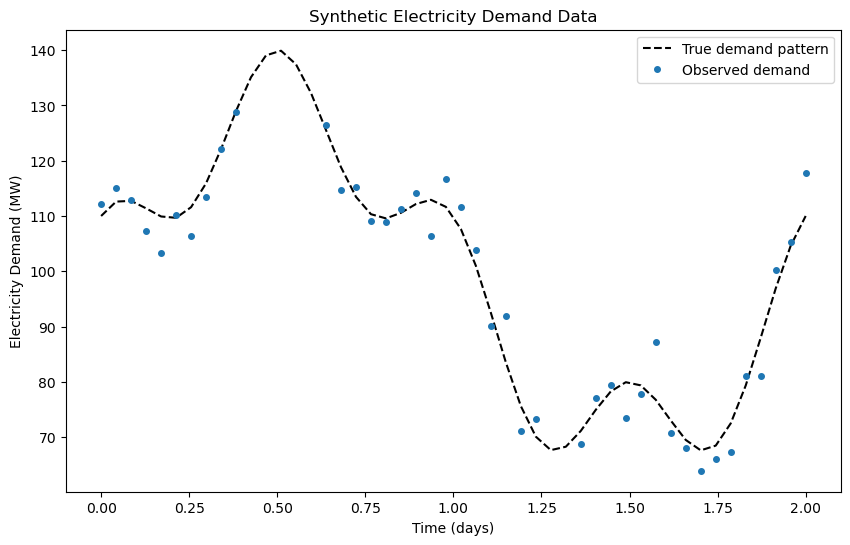

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls_daily, period, amplitude, sigma, demand_pred]


In [ ]:
# Generate synthetic electricity demand data 
# Let's create hourly electricity demand data with daily patterns
n = 48  # Two days of hourly data
hours = np.linspace(0, 2, n)  # 2 days
true_demand = 100 + 30 * np.sin(hours * np.pi) + 10 * np.cos(hours * 4 * np.pi)  # Base + daily cycle + noise

# Add some noise 
noise_level = 5
observed_demand = true_demand + np.random.normal(0, noise_level, n)

# Add "missing" data points 
mask = np.ones(n, dtype=bool)
mask[10:15] = False  
mask[30:32] = False 

plt.figure(figsize=(10, 6))
plt.plot(hours, true_demand, 'k--', label='True demand pattern')
plt.plot(hours[mask], observed_demand[mask], 'o', ms=4, label='Observed demand')
plt.xlabel('Time (days)')
plt.ylabel('Electricity Demand (MW)')
plt.title('Synthetic Electricity Demand Data')
plt.legend()
plt.show()


with pm.Model() as gp_model:
    # covariance function
    ls_daily = pm.HalfNormal("ls_daily", sigma=1.0)  # Length scale for daily pattern
    period = pm.Normal("period", mu=1.0, sigma=0.1)  # Period of 1 day with some uncertainty
    amplitude = pm.HalfNormal("amplitude", sigma=20.0)  # Signal amplitude
    

    cov_func = amplitude * pm.gp.cov.Periodic(1, period, ls_daily)
    
    # white noise for observations
    sigma = pm.HalfNormal("sigma", sigma=10.0)
    
    # Gaussian Process
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    # for the observed data
    demand_obs = gp.marginal_likelihood("demand_obs", X=hours[mask].reshape(-1, 1), 
                                       y=observed_demand[mask], sigma=sigma)
    
    # Predict at all points 
    demand_pred = gp.conditional("demand_pred", hours.reshape(-1, 1))
    
    # Sample posterior
    idata = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)


with gp_model:
    # Get posterior samples for prediction
    pred_samples = pm.sample_posterior_predictive(
        idata, var_names=["demand_pred"], random_seed=42
    )

# Calculate mean and credible intervals
pred_mean = pred_samples.posterior_predictive["demand_pred"].mean(dim=["chain", "draw"])
pred_hdi = az.hdi(pred_samples.posterior_predictive["demand_pred"])

# Plot the final results
plt.figure(figsize=(10, 6))
plt.plot(hours, true_demand, 'k--', label='True demand pattern')
plt.plot(hours[mask], observed_demand[mask], 'o', ms=4, label='Observed data')
plt.plot(hours, pred_mean, 'b-', label='GP mean prediction')
plt.fill_between(hours, pred_hdi.demand_pred.sel(hdi="lower"), 
                 pred_hdi.demand_pred.sel(hdi="higher"), 
                 alpha=0.3, color='b', label='95% credible interval')
plt.xlabel('Time (days)')
plt.ylabel('Electricity Demand (MW)')
plt.title('Gaussian Process Regression for Electricity Demand Forecasting')
plt.legend()
plt.show()


summary = az.summary(idata, var_names=["ls_daily", "period", "amplitude", "sigma"])
print("Model Parameter Estimates:")
print(summary)

In [ ]:
n_samples = 500
temperature = np.random.uniform(10, 35, n_samples) 
cloud_cover = np.random.uniform(0, 1, n_samples)   
humidity = np.random.uniform(30, 90, n_samples)    
wind_speed = np.random.uniform(0, 15, n_samples)    


power_output = (20 * np.sin(temperature/30) - 
                25 * cloud_cover**2 + 
                temperature * (1 - cloud_cover) / 3 + 
                0.1 * humidity * (1 - cloud_cover) + 
                0.5 * wind_speed * (wind_speed < 8) - 
                0.2 * wind_speed * (wind_speed >= 8))


power_output += np.random.normal(0, 5, n_samples)
power_output = np.maximum(0, power_output)

data = pd.DataFrame({
    'Temperature': temperature,
    'CloudCover': cloud_cover,
    'Humidity': humidity,
    'WindSpeed': wind_speed,
    'PowerOutput': power_output
})

# Split the data
X = data[['Temperature', 'CloudCover', 'Humidity', 'WindSpeed']].values
y = data['PowerOutput'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize 
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Define neural network architecture
n_features = X_train.shape[1]
n_hidden = 10  # Size of hidden layer
n_output = 1   # Single output (power prediction)


with pm.Model() as nn_model:
    # Priors for weights and biases using Normal priors
    weights_in = pm.Normal('weights_in', 0, 1, shape=(n_features, n_hidden))
    bias_in = pm.Normal('bias_in', 0, 1, shape=n_hidden)
    
    weights_out = pm.Normal('weights_out', 0, 1, shape=(n_hidden, n_output))
    bias_out = pm.Normal('bias_out', 0, 1, shape=n_output)
    
    # Neural network single hidden layer with tanh activation
    act_in = pm.math.tanh(pm.math.dot(X_train_scaled, weights_in) + bias_in)
    y_pred = pm.math.dot(act_in, weights_out) + bias_out
    
    # likelihood
    sigma = pm.HalfNormal('sigma', 1.0)
    likelihood = pm.Normal('likelihood', mu=y_pred, sigma=sigma, observed=y_train_scaled.reshape(-1, 1))
    
    # ADVI for variational inference
    approx = pm.fit(
        method='advi',
        n=20000,  # Number of iterations
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)]
    )
    
    # Sample from the posterior
    trace = approx.sample(1000)
    idata = az.from_pymc(trace)

# Evaluate performance 
with nn_model:
    # Get samples of parameters
    weights_in_post = idata.posterior['weights_in'].values
    bias_in_post = idata.posterior['bias_in'].values
    weights_out_post = idata.posterior['weights_out'].values
    bias_out_post = idata.posterior['bias_out'].values
    
    # Function to predict using the neural network
    def predict(X, w_in, b_in, w_out, b_out):
        act = np.tanh(np.dot(X, w_in) + b_in)
        return np.dot(act, w_out) + b_out
    
    # Make predictions for each posterior sample
    n_samples = len(weights_in_post)
    test_preds = np.zeros((n_samples, len(X_test_scaled), 1))
    
    for i in range(n_samples):
        test_preds[i] = predict(
            X_test_scaled, 
            weights_in_post[i], 
            bias_in_post[i], 
            weights_out_post[i], 
            bias_out_post[i]
        )
    
    # Calculate mean predictions and scale back
    pred_mean = test_preds.mean(axis=0)
    pred_std = test_preds.std(axis=0)
    
    pred_mean_original = scaler_y.inverse_transform(pred_mean)
    
    # Calculate error metrics
    mse = np.mean((pred_mean_original.flatten() - y_test)**2)
    rmse = np.sqrt(mse)


plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred_mean_original, alpha=0.5)
min_val, max_val = min(y_test.min(), pred_mean_original.min()), max(y_test.max(), pred_mean_original.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Actual Power Output')
plt.ylabel('Predicted Power Output')
plt.title(f'Neural Network with VI/ADVI\nRMSE: {rmse:.2f}')
plt.grid(True, alpha=0.3)
plt.show()

# Plot ELBO convergence
plt.figure(figsize=(10, 4))
plt.plot(approx.hist)
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ELBO Convergence During VI Training')
plt.grid(True, alpha=0.3)
plt.show()

# Plot feature importance using sensitivity analysis
plt.figure(figsize=(10, 6))
feature_names = ['Temperature', 'Cloud Cover', 'Humidity', 'Wind Speed']

# Simple sensitivity analysis for feature importance
importance = np.zeros(n_features)
for i in range(n_features):
    # Create modified input where one feature is increased
    X_test_mod = X_test_scaled.copy()
    X_test_mod[:, i] += 0.1  # Small increase
    
    # Predict with original and modified input
    preds_orig = predict(X_test_scaled, weights_in_post.mean(axis=0), 
                         bias_in_post.mean(axis=0),
                         weights_out_post.mean(axis=0),
                         bias_out_post.mean(axis=0))
    
    preds_mod = predict(X_test_mod, weights_in_post.mean(axis=0), 
                        bias_in_post.mean(axis=0),
                        weights_out_post.mean(axis=0),
                        bias_out_post.mean(axis=0))
    
    importance[i] = np.abs(preds_mod - preds_orig).mean()

plt.bar(feature_names, importance)
plt.title('Feature Sensitivity Analysis')
plt.ylabel('Average Impact on Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"RMSE on test data: {rmse:.2f}")
print(f"Final ELBO value: {approx.hist[-1]:.2f}")